# Grocery Expance Analyser

Jupyter Notebook created to categorize .csv based bank statment expances.  

Currently suppoorted bank account export format is `ING Bank Śląski` which can aggreagate expances form other banks.

I wrote it to analyze bank account statment to determine grocery expances and asess inflation over the years.

# Export data from Bank accounts


**ING Bank Śląski** -  Export the accounts you would like to do analysis for. Usually I'm esporting expances from all accounts except `Rachunki` bank account to see how much money was spenf to things like grocery. Exported file have `.csv` format and `cp-1250` encoding.

Data presnetation article
https://www.shanelynn.ie/data-visualisation-in-python-pycon-dublin-2018-presentation/




# Input Data

In [1]:
# Uncomment data sources which you would like to analyse. 

CSV_LIST = [
    "data/2025.csv",
    "data/2024.csv",
    "data/2023.csv",
    "data/2022.csv",
#     "data/2021.csv",
#     "data/2020.csv",
#     "data/2019.csv",
#     "data/2018.csv",
]


# 1. ING Bank Śląski



## 1.1 Import Data from ING Bank Sląski

Import raw data from .csv file.

`header` - is an index of non empty row in input csv file. Will be used as `df` column name.


In [2]:
import pandas as pd
from tabulate import tabulate

from helper import get_ing_header_row_index

# Dataframe print settings
pd.set_option('display.max_rows', None) # Show all rows
pd.set_option('display.max_columns', None) # Show all columns
pd.set_option('display.max_colwidth', None) # Optional: prevent truncating column width
pd.set_option('display.width', None) # Optional: wide display for Jupyter environments

# CSV file settings 
ING_ENCODING = "cp1250"
ING_SEP = ";"

def import_csv_to_df(csv_file):
    """
    Import CSV file to pandas DataFrame.
    """
    
    ing_raw_df = pd.read_csv(
        csv_file,
        encoding=ING_ENCODING,
        sep=ING_SEP,
        header=get_ing_header_row_index(
            csv_file, ING_ENCODING
        ),
    )

    # Trim data frame - Drop last row which is empty
    ing_raw_df.drop(ing_raw_df.tail(1).index, inplace=True)

    return ing_raw_df


In [3]:

# Analyse batch of CSV files specified in CSV_LIST. 
# One file is special case which is working as well :)

df_list = [import_csv_to_df(csv_file) for csv_file in CSV_LIST]
df = pd.concat(df_list, ignore_index=True)


## 1.2 - Data preparation

Ceanup the data from ING Bank account to extract only usefull columns

* Trim data fame to get only usefull columns for analysis
* Manipulate data
* Set data types


In [4]:
# *** TRIM DATA FRAME ***

# Drop columns with "Unnamed" in the header
df = df.loc[:, ~df.columns.str.startswith("Unnamed")]


# *** MODIFY DATA FRAME *** 

"""
COPY Kwota blokady/zwolnienie blokady ->  Kwota transakcji (waluta rachunku). 
This is the case when the transaction is a blocked.
"""

df = df.copy() # needed due to error
df.loc[
    df["Kwota transakcji (waluta rachunku)"].isna(),
    "Kwota transakcji (waluta rachunku)"
] = df["Kwota blokady/zwolnienie blokady"]

"""
RENAME Kwota transakcji (waluta rachunku) -> Kwota transakcji
"""

df = df.rename(columns={"Kwota transakcji (waluta rachunku)": "Kwota transakcji"})


"""
IF Dane kontrahenta empty COPY Tytuł
"""

df["Dane kontrahenta"] = df.apply(
    lambda row: row["Tytuł"] if not row["Dane kontrahenta"].strip() else row["Dane kontrahenta"],
    axis=1
)

# *** Select only needed columns ***

"""
Columns: Data transakcji; Dane kontrahenta; Kwota transakcji; Kategoria
"""
df = df.copy()
df = df[["Data transakcji", "Dane kontrahenta", "Kwota transakcji"]]
df["Kategoria"] = "NaN"


# *** SET data types for columns ***

df["Data transakcji"] = df["Data transakcji"].astype("datetime64[ns]")
df["Dane kontrahenta"] = df["Dane kontrahenta"].astype(str)

df["Kwota transakcji"] = df["Kwota transakcji"].str.replace(",", ".").astype(float) # Replace comma with dot
df["Kwota transakcji"] = df["Kwota transakcji"].astype(float)
df["Kwota transakcji"] = -df["Kwota transakcji"] # Change the sign of "Kwota transakcji" column

df["Kategoria"] = df["Kategoria"].astype(str)


In [5]:
df.dtypes

Data transakcji     datetime64[ns]
Dane kontrahenta            object
Kwota transakcji           float64
Kategoria                   object
dtype: object

In [6]:
df.shape

(8734, 4)

In [7]:
df.sample(10)

,Data transakcji,Dane kontrahenta,Kwota transakcji,Kategoria
2818,2024-01-21,ZABKA Z6649 K.1 WROCLAW 5014 POL,35.40,NaN
6300,2022-11-02,BP-LECH JET WASH 555 SZCZECIN POL,2.00,NaN
8261,2022-03-12,SKLEP LIDL 1196 SZC SZCZECIN PL,43.23,NaN
5297,2023-02-28,LOMAX DABIE STACJA SZCZECIN POL,34.98,NaN
6205,2022-11-11,UBER *TRIP Amsterdam NLD,3.44,NaN
5164,2023-03-15,SODEL ALBERT ŁUKASZ JAGODNE 100 27-220 MIRZEC,-300.00,NaN
7544,2022-06-01,IKEA RETAIL SP. Z O SZCZECIN PL,7.49,NaN
5747,2023-01-07,JMP S.A. BIEDRONKA 3073 SZCZECIN,7.28,NaN
249,2025-03-10,Rata pozaplanowa z 560803741 @LNPMT @90336718131201117 @LNPMT@903367181 31201117,2000.00,NaN
2129,2024-05-16,SODEL WERONIKA UL KURPIÓW 13M4 70-8 54 SZCZECIN SZCZECIN POLSKA,1000.00,NaN


## 1.3 Categorize ING Bank Statment Data


In [8]:
# Keywords for each category
category_keywords = {
    "Zakupy spożywcze": ["biedronka", "lidl", "kaufland", "carrefour", "netto", "zabka", "freshmarket",
                          "stokrotka", "auchan", "selgros", "tesco", "intermarche", "leclerc", "freshmarket", "piekar"],
    # "Paliwo": ["orlen", "bp", "shell"],
    # "Restauracje": ["mcdonald", "kfc", "pizza"],
}

# Lowercase "Dane kontrahenta" for case-insensitive matching
df["Dane_lower"] = df["Dane kontrahenta"].str.lower()


# Function to find category
def find_category(dane):
    for category, keywords in category_keywords.items():
        if any(keyword in dane for keyword in keywords):
            return category
    return "Inne"  # default if no match

# Apply the function
df["Kategoria"] = df["Dane_lower"].apply(find_category)

# Drop helper column if not needed
df.drop(columns=["Dane_lower"], inplace=True)


# DEBUG: Save the dataframe as an Excel file
# df.to_csv("test.csv", sep=";", index=False, encoding=ING_ENCODING)

df_categorized =  df[df["Kategoria"] == "Zakupy spożywcze"]


## 1.4 Data Visualisation


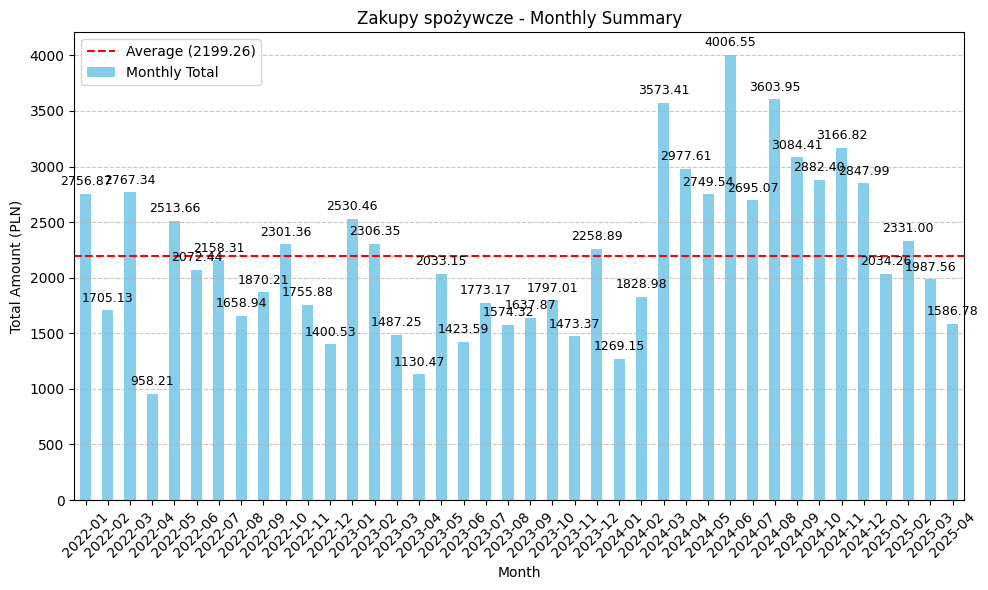

In [9]:
import matplotlib.pyplot as plt

# Group by month and sum the transaction amounts for "Zakupy spożywcze"
df_categorized = df_categorized.copy()
df_categorized["Month"] = df_categorized["Data transakcji"].dt.to_period("M")
monthly_summary_grocery = df_categorized.groupby("Month")["Kwota transakcji"].sum()

# Calculate the average value
average_value = monthly_summary_grocery.mean()

# Plot the monthly summary
ax = monthly_summary_grocery.plot(kind="bar", figsize=(10, 6), color="skyblue", label="Monthly Total")
plt.axhline(y=average_value, color="red", linestyle="--", label=f"Average ({average_value:.2f})")
plt.title("Zakupy spożywcze - Monthly Summary")
plt.xlabel("Month")
plt.ylabel("Total Amount (PLN)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add data labels at the end of each bar
for i, value in enumerate(monthly_summary_grocery):
    ax.text(i, value + 50, f"{value:.2f}", ha="center", va="bottom", fontsize=9)

plt.legend()
plt.tight_layout()
plt.show()
